In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import zhinst.toolkit as tk

In [2]:
mdc = tk.MultiDeviceConnection()
mdc.setup()

Successfully connected to data server at localhost8004 api version: 6


In [3]:
hd = tk.HDAWG("hd", "dev8030", interface="1GbE")
qa = tk.UHFQA("qa", "dev2266", interface="1GbE")

In [4]:
mdc.connect_device(hd)
mdc.connect_device(qa)

Successfully connected to device DEV8030 on interface 1GBE
Successfully connected to device DEV2266 on interface 1GBE


In [17]:
averages = 2**3
period = 0.2

drive_freq = 78.54e6
delays = np.linspace(0, 10e-6, 51)

int_time = 2e-6

In [18]:
hd.awgs[0].disable_iq_modulation()
hd.awgs[0].set_sequence_params(
    sequence_type="Simple",
    period=period,
    repetitions=averages,
    alignment="End with Trigger",
    trigger_mode="Send Trigger",
)

In [19]:
hd.awgs[0]

hd: <zhinst.toolkit.hdawg.AWG object at 0x0000019AE4048630>
    parent  : <zhinst.toolkit.hdawg.HDAWG object at 0x0000019AE40484A8>
    index   : 0
    sequence: 
           type: Simple
            ('target', 'hdawg')
            ('clock_rate', 2400000000.0)
            ('period', 0.2)
            ('trigger_mode', 'Send Trigger')
            ('repetitions', 8)
            ('alignment', 'End with Trigger')
            ('n_HW_loop', 11)
            ('dead_time', 5e-06)
            ('trigger_delay', 0)
            ('latency', 1.6e-07)
            ('trigger_cmd_1', 'setTrigger(1);\n')
            ('trigger_cmd_2', 'setTrigger(0);\n')
            ('wait_cycles', 59998500)
            ('dead_cycles', 1500)
            ('reset_phase', False)
            ('buffer_lengths', [1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008])
            ('delay_times', [1e-06, 1.1e-06, 1.2e-06, 1.2999999999999998e-06, 1.4e-06, 1.5e-06, 1.6e-06, 1.6999999999999998e-06, 1.8e-06, 1.9e-06, 2e-06])


In [20]:
hd.awgs[0].reset_queue()
for d in delays:
    hd.awgs[0].queue_waveform(np.ones(1000), -np.ones(1000), delay=d)

Current length of queue: 1
Current length of queue: 2
Current length of queue: 3
Current length of queue: 4
Current length of queue: 5
Current length of queue: 6
Current length of queue: 7
Current length of queue: 8
Current length of queue: 9
Current length of queue: 10
Current length of queue: 11
Current length of queue: 12
Current length of queue: 13
Current length of queue: 14
Current length of queue: 15
Current length of queue: 16
Current length of queue: 17
Current length of queue: 18
Current length of queue: 19
Current length of queue: 20
Current length of queue: 21
Current length of queue: 22
Current length of queue: 23
Current length of queue: 24
Current length of queue: 25
Current length of queue: 26
Current length of queue: 27
Current length of queue: 28
Current length of queue: 29
Current length of queue: 30
Current length of queue: 31
Current length of queue: 32
Current length of queue: 33
Current length of queue: 34
Current length of queue: 35
Current length of queue: 36
C

In [21]:
hd.awgs[0].compile_and_upload_waveforms()

Compilation successful
hd-0: Sequencer status: ELF file uploaded
Upload of 51 waveforms took 0.025965 s


In [22]:
qa.awg.set_sequence_params(
    sequence_type="Readout",
    repetitions=averages * len(delays),
    period=period,
    alignment="Start with Trigger",
    trigger_mode="External Trigger",
    readout_length=int_time,
    trigger_delay=-30e-9,
)

# prepare readout channel on UHFQA
qa.integration_time(int_time)
qa.channels[0].enable()
qa.channels[0].readout_frequency(drive_freq)
qa.channels[0].rotation(0)

qa.awg.compile()

Compilation successful
qa-0: Sequencer status: ELF file uploaded


In [23]:
hd.awgs[0].output1("on")
qa.awg.outputs("on")

In [25]:
# configure result acquisition

qa.result_source("integration")
qa.nodetree.qa.result.length(len(delays)*averages)
qa.nodetree.qa.result.averages(1)
qa.nodetree.qa.result.enable(1)
qa.nodetree.qa.result.reset(0)
qa.nodetree.qa.result.reset(1)

1

In [26]:
# acquire data only at the end of the measurement
tik = time.time()

qa.awg.run()
time.sleep(0.1)
hd.awgs[0].run()
hd.awgs[0].wait_done(timeout=100)
    
res = qa.channels[0].result()

print(time.time() - tik)

81.85615038871765


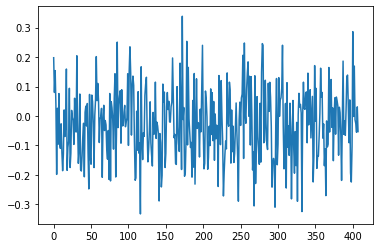

In [27]:
plt.plot(np.real(res))